In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "high_z"
key = "lambda"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

13it [00:00, 129.32it/s]

28it [00:00, 132.59it/s]

40it [00:00, 127.38it/s]

54it [00:00, 130.62it/s]

66it [00:00, 126.72it/s]

81it [00:00, 130.70it/s]

94it [00:00, 128.88it/s]

108it [00:00, 131.99it/s]

123it [00:00, 134.71it/s]

137it [00:01, 121.48it/s]

150it [00:01, 109.60it/s]

162it [00:01, 104.66it/s]

175it [00:01, 110.92it/s]

190it [00:01, 118.26it/s]

204it [00:01, 123.54it/s]

218it [00:01, 125.31it/s]

231it [00:01, 111.28it/s]

243it [00:02, 103.59it/s]

254it [00:02, 93.07it/s] 

266it [00:02, 98.49it/s]

279it [00:02, 105.56it/s]

293it [00:02, 113.37it/s]

305it [00:02, 113.45it/s]

318it [00:02, 116.98it/s]

332it [00:02, 121.49it/s]

347it [00:02, 126.79it/s]

362it [00:03, 130.61it/s]

376it [00:03, 133.24it/s]

390it [00:03, 134.57it/s]

404it [00:03, 136.05it/s]

418it [00:03, 137.17it/s]

432it [00:03, 136.44it/s]

446it [00:03, 137.25it/s]

460it [00:03, 130.41it/s]

474it [00:03, 133.05it/s]

488it [00:03, 133.66it/s]

502it [00:04, 119.88it/s]

517it [00:04, 125.65it/s]

531it [00:04, 129.10it/s]

546it [00:04, 132.18it/s]

560it [00:04, 134.35it/s]

574it [00:04, 135.79it/s]

589it [00:04, 137.87it/s]

604it [00:04, 138.90it/s]

618it [00:04, 129.58it/s]

632it [00:05, 130.72it/s]

646it [00:05, 113.67it/s]

659it [00:05, 116.24it/s]

671it [00:05, 116.26it/s]

685it [00:05, 121.59it/s]

698it [00:05, 122.80it/s]

711it [00:05, 123.21it/s]

724it [00:05, 123.67it/s]

739it [00:05, 128.29it/s]

752it [00:06, 121.15it/s]

767it [00:06, 126.80it/s]

782it [00:06, 131.12it/s]

797it [00:06, 134.40it/s]

811it [00:06, 125.82it/s]

824it [00:06, 125.51it/s]

837it [00:06, 126.72it/s]

851it [00:06, 129.80it/s]

865it [00:06, 132.57it/s]

879it [00:07, 129.27it/s]

893it [00:07, 131.94it/s]

907it [00:07, 123.90it/s]

922it [00:07, 128.58it/s]

936it [00:07, 100.23it/s]

948it [00:07, 97.97it/s] 

962it [00:07, 106.38it/s]

976it [00:07, 113.73it/s]

990it [00:08, 120.21it/s]

1004it [00:08, 124.98it/s]

1018it [00:08, 129.10it/s]

1032it [00:08, 131.85it/s]

1047it [00:08, 134.57it/s]

1061it [00:08, 135.34it/s]

1075it [00:08, 135.74it/s]

1089it [00:08, 136.10it/s]

1103it [00:08, 137.23it/s]

1118it [00:08, 138.11it/s]

1132it [00:09, 129.94it/s]

1147it [00:09, 132.83it/s]

1161it [00:09, 112.70it/s]

1173it [00:09, 104.63it/s]

1184it [00:09, 100.25it/s]

1195it [00:09, 93.67it/s] 

1205it [00:09, 93.07it/s]

1215it [00:09, 91.95it/s]

1229it [00:10, 100.98it/s]

1243it [00:10, 110.10it/s]

1245it [00:10, 122.36it/s]


0it [00:00, ?it/s]

16it [00:00, 150.52it/s]

Number of empty sat catalogs is 0


31it [00:00, 147.82it/s]

46it [00:00, 147.60it/s]

60it [00:00, 145.04it/s]

75it [00:00, 143.71it/s]

90it [00:00, 143.51it/s]

105it [00:00, 143.68it/s]

120it [00:00, 144.68it/s]

135it [00:00, 145.63it/s]

149it [00:01, 134.03it/s]

163it [00:01, 115.81it/s]

175it [00:01, 102.21it/s]

186it [00:01, 100.99it/s]

197it [00:01, 99.06it/s] 

210it [00:01, 105.29it/s]

224it [00:01, 113.36it/s]

239it [00:01, 121.20it/s]

254it [00:02, 126.73it/s]

268it [00:02, 117.68it/s]

283it [00:02, 125.38it/s]

297it [00:02, 129.42it/s]

312it [00:02, 134.31it/s]

326it [00:02, 128.12it/s]

341it [00:02, 133.93it/s]

356it [00:02, 137.70it/s]

370it [00:02, 135.48it/s]

385it [00:02, 138.55it/s]

400it [00:03, 140.56it/s]

415it [00:03, 141.10it/s]

430it [00:03, 141.63it/s]

445it [00:03, 142.12it/s]

460it [00:03, 135.60it/s]

475it [00:03, 137.97it/s]

490it [00:03, 139.59it/s]

505it [00:03, 141.22it/s]

520it [00:03, 141.98it/s]

535it [00:04, 143.11it/s]

550it [00:04, 143.49it/s]

565it [00:04, 144.30it/s]

580it [00:04, 143.24it/s]

595it [00:04, 143.58it/s]

610it [00:04, 144.36it/s]

625it [00:04, 143.70it/s]

640it [00:04, 134.63it/s]

655it [00:04, 137.10it/s]

670it [00:05, 138.95it/s]

685it [00:05, 139.62it/s]

700it [00:05, 141.01it/s]

715it [00:05, 122.49it/s]

728it [00:05, 122.18it/s]

743it [00:05, 128.98it/s]

758it [00:05, 133.06it/s]

773it [00:05, 136.43it/s]

787it [00:05, 111.73it/s]

802it [00:06, 119.85it/s]

817it [00:06, 126.93it/s]

832it [00:06, 132.99it/s]

846it [00:06, 117.65it/s]

859it [00:06, 120.79it/s]

873it [00:06, 124.73it/s]

888it [00:06, 130.62it/s]

903it [00:06, 134.03it/s]

918it [00:06, 137.21it/s]

933it [00:07, 139.83it/s]

948it [00:07, 118.13it/s]

961it [00:07, 103.48it/s]

975it [00:07, 111.09it/s]

990it [00:07, 119.55it/s]

1005it [00:07, 125.55it/s]

1019it [00:07, 108.71it/s]

1034it [00:07, 116.80it/s]

1047it [00:08, 116.58it/s]

1060it [00:08, 119.95it/s]

1075it [00:08, 126.92it/s]

1090it [00:08, 132.68it/s]

1105it [00:08, 136.65it/s]

1120it [00:08, 139.96it/s]

1135it [00:08, 141.86it/s]

1150it [00:08, 142.08it/s]

1165it [00:08, 142.24it/s]

1180it [00:09, 144.05it/s]

1195it [00:09, 137.34it/s]

1210it [00:09, 140.06it/s]

1225it [00:09, 142.54it/s]

1240it [00:09, 143.09it/s]

1245it [00:09, 131.50it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

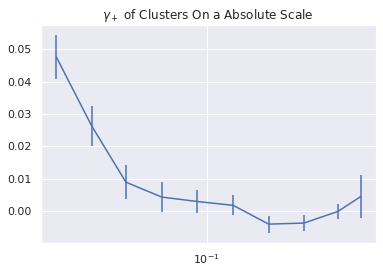

Aggregated xi:
[ -9.4713 -10.0045  -5.4587  -4.2605  -5.1078  -4.6187  14.5739  16.3042
   0.3743  -2.6797]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -861.2847 -1463.5779 -2067.6664 -2850.3429 -4157.1705 -5007.5907
 -5345.1021 -4389.4388 -2333.6818  -134.1704]
------------------------------------------------------------------------------
Aggregated npairs:
[ 199.  380.  610.  981. 1714. 2578. 3648. 4431. 4389.  597.]
------------------------------------------------------------------------------
Mean xi:
[-4.7594e-02 -2.6328e-02 -8.9486e-03 -4.3430e-03 -2.9800e-03 -1.7916e-03
  3.9950e-03  3.6796e-03  8.5281e-05 -4.4886e-03]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3281 -3.8515 -3.3896 -2.9055 -2.4254 -1.9424 -1.4652 -0.9906 -0.5317
 -0.2247]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

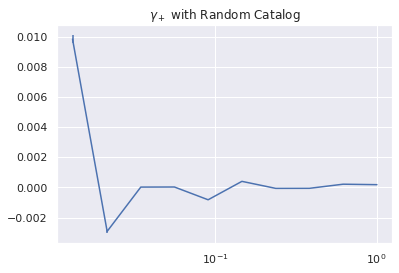

[ 9.8275e-03 -2.9159e-03  1.9740e-05  2.5301e-05 -8.2103e-04  3.9983e-04
 -6.5348e-05 -6.1656e-05  2.1127e-04  1.8010e-04]
[-2.7852e-04  8.2638e-05 -5.5944e-07 -7.1707e-07  2.3269e-05 -1.1332e-05
  1.8520e-06  1.7474e-06 -5.9876e-06 -5.1042e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

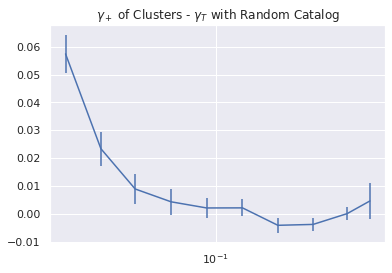

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

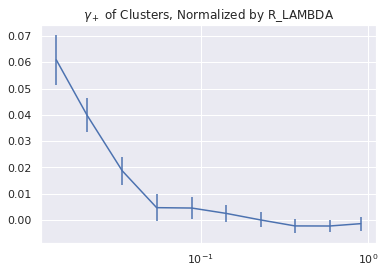

Aggregated xi:
[-5.5435 -9.7283 -8.8815 -3.3288 -5.4573 -4.9357 -0.0264  8.8566 10.6223
  4.7735]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -390.2688  -943.2825 -1603.5455 -2062.9348 -2909.8725 -3830.6417
 -4265.3853 -3961.5915 -2473.2561  -361.1402]
------------------------------------------------------------------------------
Aggregated npairs:
[  91.  244.  474.  709. 1199. 1959. 2886. 3931. 4647. 3423.]
------------------------------------------------------------------------------
Mean xi:
[-6.0917e-02 -3.9870e-02 -1.8737e-02 -4.6951e-03 -4.5515e-03 -2.5195e-03
 -9.1448e-06  2.2530e-03  2.2858e-03  1.3945e-03]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2887 -3.8659 -3.383  -2.9096 -2.4269 -1.9554 -1.478  -1.0078 -0.5322
 -0.1055]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)